# GraphRAG Sample - Indexing, Querying, and Visualization

This notebook demonstrates:
1. Dataset download for GraphRAG testing
2. Indexing with GraphRAG API
3. Global Search (map-reduce over communities)
4. Local Search (entity/relationship context)
5. DRIFT Search (multi-turn exploration)
6. Graph visualization

## 1. Setup and Configuration

In [26]:
# Install required packages
# %pip install python-dotenv networkx matplotlib --quiet

In [ ]:
# Suppress verbose error traces and warnings
import sys
import warnings
import logging
import os

# Fix Windows Unicode encoding issues in logging (only for standard Python, not Jupyter)
if sys.platform == 'win32':
    os.environ['PYTHONIOENCODING'] = 'utf-8'
    # Try to set UTF-8 encoding if buffer exists (standard Python)
    try:
        import io
        if hasattr(sys.stdout, 'buffer'):
            sys.stdout = io.TextIOWrapper(sys.stdout.buffer, encoding='utf-8', errors='replace')
            sys.stderr = io.TextIOWrapper(sys.stderr.buffer, encoding='utf-8', errors='replace')
    except:  # noqa: E722
        pass  # Jupyter already handles encoding

# Suppress warnings
warnings.filterwarnings('ignore')

# Completely disable all logging to prevent encoding errors
logging.disable(logging.CRITICAL)

# Remove all existing handlers and add a null handler
root_logger = logging.getLogger()
for handler in root_logger.handlers[:]:
    root_logger.removeHandler(handler)
root_logger.addHandler(logging.NullHandler())

# Set all loggers to CRITICAL level
for name in ['asyncio', 'graphrag', 'urllib3', 'openai', 'litellm']:
    logging.getLogger(name).setLevel(logging.CRITICAL)
    logging.getLogger(name).handlers = [logging.NullHandler()]

# Suppress logging errors themselves
logging.raiseExceptions = False

# Hide file paths in IPython/Jupyter tracebacks
try:
    from IPython import get_ipython
    ipython = get_ipython()
    if ipython:
        ipython.run_line_magic('xmode', 'Minimal')
        print("✓ Minimal traceback mode enabled")
except:  # noqa: E722
    pass

print("✓ All logging disabled (including Unicode encoding errors)")
print("✓ Verbose output suppressed")

Exception reporting mode: Minimal
✓ Minimal traceback mode enabled
✓ All logging disabled (including Unicode encoding errors)
✓ Verbose output suppressed


In [28]:
import pandas as pd
from pathlib import Path
import requests

# Indexing
from graphrag.api.index import build_index
from graphrag.config.models.graph_rag_config import GraphRagConfig
from graphrag.config.enums import IndexingMethod

# Query setup
from graphrag.config.enums import ModelType
from graphrag.config.models.vector_store_schema_config import VectorStoreSchemaConfig
from graphrag.vector_stores.lancedb import LanceDBVectorStore

# Query adapters
from graphrag.query.indexer_adapters import (
    read_indexer_entities,
    read_indexer_relationships,
    read_indexer_reports,
    read_indexer_text_units,
    read_indexer_report_embeddings,
)

# Global search
from graphrag.query.structured_search.global_search.community_context import GlobalCommunityContext
from graphrag.query.structured_search.global_search.search import GlobalSearch

# Local search
from graphrag.query.context_builder.entity_extraction import EntityVectorStoreKey
from graphrag.query.structured_search.local_search.mixed_context import LocalSearchMixedContext
from graphrag.query.structured_search.local_search.search import LocalSearch

# DRIFT search
from graphrag.config.models.drift_search_config import DRIFTSearchConfig
from graphrag.query.structured_search.drift_search.drift_context import DRIFTSearchContextBuilder
from graphrag.query.structured_search.drift_search.search import DRIFTSearch

print("✓ All imports successful")

✓ All imports successful


## 2. Download Test Dataset

In [29]:
def download_graphrag_paper(output_dir: str = "./dataset"):
    """Download GraphRAG research paper for testing."""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    
    print("Downloading GraphRAG research paper...")
    url = "https://arxiv.org/pdf/2404.16130"
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    
    output_path = output_dir / "graphrag_paper.pdf"
    output_path.write_bytes(response.content)
    
    print(f"✓ Saved to: {output_path}")
    print(f"  Size: {len(response.content):,} bytes")
    return output_path

# Download dataset
dataset_path = download_graphrag_paper()

✓ Saved to: dataset\graphrag_paper.pdf
  Size: 6,893,854 bytes


#### Convert pdf file to Markdown

In [30]:
from markitdown import MarkItDown

md = MarkItDown(enable_plugins=False) # Set to True to enable plugins
result = md.convert(dataset_path)
content = result.text_content
input_file_path = Path("./dataset").parent / "input" / "input.txt"

# Write text content to input file
with open(input_file_path, "w", encoding="utf-8") as f:
    f.write(content)

# Verify input file
if os.path.exists(input_file_path):
    print(f"✓ Input file created at: {input_file_path}")
    print(f"  Size: {os.path.getsize(input_file_path):,} bytes")

✓ Input file created at: input\input.txt
  Size: 93,526 bytes


## 3. Indexing (Optional - if not already indexed)

#### ⚠️ IMPORTANT: Run This Pre-Flight Check First!

#### ✅ Ready to Run Indexing!

**Now run the indexing cell below!**

In [31]:
# Pre-flight check: Verify Azure OpenAI configuration BEFORE indexing
from dotenv import load_dotenv
from openai import AzureOpenAI
import yaml

print("🔍 PRE-FLIGHT CHECK")
print("="*60)

# Load environment
load_dotenv(override=True)
api_key = os.getenv('GRAPHRAG_API_KEY')

# Load settings
with open("./settings.yaml", "r", encoding="utf-8") as f:
    settings = yaml.safe_load(f)

endpoint = settings['models']['default_chat_model']['api_base']
deployment = settings['models']['default_chat_model']['deployment_name']
api_version = settings['models']['default_chat_model']['api_version']

print("\n1. Environment Variables:")
print(f"   ✓ API Key: {api_key[:10]}...{api_key[-4:]} ({len(api_key)} chars)")

print("\n2. Settings.yaml Configuration:")
print(f"   ✓ Deployment: {deployment}")
print(f"   ✓ API Version: {api_version}")

print("\n3. Testing Live Connection...")
try:
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=endpoint
    )
    
    response = client.chat.completions.create(
        model=deployment,
        messages=[{"role": "user", "content": "Test"}],
        max_completion_tokens=5
    )
    
    print(f"   ✅ SUCCESS! Connected to {response.model}")
    print(f"\n{'='*60}")
    print("✅ ALL CHECKS PASSED - You can proceed with indexing!")
    print("="*60)
    
except Exception as e:
    print(f"   ❌ FAILED: {type(e).__name__}")
    print(f"   Error: {str(e)[:200]}")
    print(f"\n{'='*60}")
    print("❌ PRE-FLIGHT CHECK FAILED")
    print("DO NOT run indexing until this passes!")
    print("="*60)
    raise

🔍 PRE-FLIGHT CHECK

1. Environment Variables:
   ✓ API Key: 99c6be8210...d15e (32 chars)

2. Settings.yaml Configuration:
   ✓ Deployment: gpt-5-mini
   ✓ API Version: 2025-04-01-preview

3. Testing Live Connection...
   ✅ SUCCESS! Connected to gpt-5-mini-2025-08-07

✅ ALL CHECKS PASSED - You can proceed with indexing!


In [47]:
import yaml
import logging
from dotenv import load_dotenv

# Step 1: Force reload environment variables
load_dotenv(override=True)
api_key = os.getenv('GRAPHRAG_API_KEY')

print("🔄 Pre-flight checks...")
print(f"   API Key: {api_key[:10]}...{api_key[-4:]} ({len(api_key)} chars)")

# Step 2: Load configuration
print("\n📋 Loading configuration...")
with open("./settings.yaml", "r", encoding="utf-8") as f:
    settings = yaml.safe_load(f)

# Ensure root_dir is set
if "root_dir" not in settings or not settings["root_dir"]:
    settings["root_dir"] = str(Path.cwd())

# ⚠️ CRITICAL FIX: Manually replace ${GRAPHRAG_API_KEY} with actual key
# GraphRAG's template substitution might not be working properly
settings['models']['default_chat_model']['api_key'] = api_key
settings['models']['default_embedding_model']['api_key'] = api_key

# Step 5: Enable logging
logging.basicConfig(level=logging.INFO, force=True)

print("\n⚙️ Creating GraphRAG config...")
config = GraphRagConfig(**settings)

print("\n🚀 Starting indexing workflow...")

# Step 6: Run indexing
results = await build_index(
    config=config,
    method=IndexingMethod.Standard,
    verbose=True
)

print("\n" + "="*60)
print("✓ Indexing complete!")
print(f"  Workflows executed: {len(results)}")
for result in results:
    status = '✓' if not result.errors else f'✗ ({len(result.errors)} errors)'
    print(f"  - {result.workflow}: {status}")
print("="*60)

🔄 Pre-flight checks...
   API Key: 99c6be8210...d15e (32 chars)

📋 Loading configuration...

⚙️ Creating GraphRAG config...

🚀 Starting indexing workflow...

✓ Indexing complete!
  Workflows executed: 10
  - load_input_documents: ✓
  - create_base_text_units: ✓
  - create_final_documents: ✓
  - extract_graph: ✓
  - finalize_graph: ✓
  - extract_covariates: ✓
  - create_communities: ✓
  - create_final_text_units: ✓
  - create_community_reports: ✓
  - generate_text_embeddings: ✓


**✅ GPT-5 Compatibility Fix Applied:**

**Problem Root Cause:**
```
Error: Invalid type for 'max_tokens': expected an unsupported value, but got null instead.
```
- GraphRAG's LiteLLM integration was sending `max_tokens: null` to Azure OpenAI
- GPT-5/GPT-4o models don't accept `max_tokens` parameter at all (even as null)
- Must use `max_completion_tokens` instead

**Complete Fix Applied:**

1. **Settings Configuration (`settings.yaml`):**
   - Set `max_completion_tokens: 4000` for GPT-5 models
   - Removed `max_tokens` parameter completely
   - Removed null `tokens_per_minute` and `requests_per_minute`

2. **Why This Was Critical:**
   - GPT-5 API strictly rejects requests with `max_tokens` parameter
   - Null values are explicitly rejected (not just ignored)
   - Solution: Don't add the key to the request dict at all
```

In [33]:
# Inspect errors from the indexing workflow
print("Detailed error information:")
for result in results:
    if result.errors:
        print(f"\n❌ Workflow: {result.workflow}")
        for error in result.errors:
            print(f"   Error: {error}")
            
# Check if the parquet files were created despite the error
output_dir = "./output"
parquet_files = [f for f in os.listdir(output_dir) if f.endswith('.parquet')]
print(f"\n📁 Parquet files created: {len(parquet_files)}")
for file in parquet_files:
    print(f"   - {file}")

Detailed error information:

📁 Parquet files created: 6
   - communities.parquet
   - community_reports.parquet
   - documents.parquet
   - entities.parquet
   - relationships.parquet
   - text_units.parquet


## 5. Load Indexed Data

In [34]:
INPUT_DIR = "./output"
COMMUNITY_LEVEL = 2

# Load parquet files
entity_df = pd.read_parquet(f"{INPUT_DIR}/entities.parquet")
community_df = pd.read_parquet(f"{INPUT_DIR}/communities.parquet")
relationship_df = pd.read_parquet(f"{INPUT_DIR}/relationships.parquet")
report_df = pd.read_parquet(f"{INPUT_DIR}/community_reports.parquet")
text_unit_df = pd.read_parquet(f"{INPUT_DIR}/text_units.parquet")

# Convert to GraphRAG objects
entities = read_indexer_entities(entity_df, community_df, COMMUNITY_LEVEL)
relationships = read_indexer_relationships(relationship_df)
reports = read_indexer_reports(report_df, community_df, COMMUNITY_LEVEL)
text_units = read_indexer_text_units(text_unit_df)

print(f"Entities: {len(entities)}")
print(f"Relationships: {len(relationships)}")
print(f"Reports: {len(reports)}")
print(f"Text units: {len(text_units)}")

Entities: 43
Relationships: 87
Reports: 11
Text units: 22


In [35]:
# Configure tokenizer and text embedder for search engines
from graphrag.tokenizer.get_tokenizer import get_tokenizer
from graphrag.language_model.manager import ModelManager

# Get configurations from settings
search_chat_config = config.get_language_model_config("default_chat_model")
embedding_config = config.get_language_model_config("default_embedding_model")

# Create tokenizer for token counting in search engines
tokenizer = get_tokenizer(search_chat_config)

# Create text embedder for vector search in local/drift search
text_embedder = ModelManager().get_or_create_embedding_model(
    name="default_embedding",
    model_type=ModelType.Embedding,
    config=embedding_config,
    cache=None
)

print("✓ Tokenizer configured")
print(f"  Model: {search_chat_config.model}")
print("✓ Text embedder configured")
print(f"  Model: {embedding_config.model}")

✓ Tokenizer configured
  Model: gpt-5-mini
✓ Text embedder configured
  Model: text-embedding-3-small


## 6. Global Search

Map-reduce search over all community reports for dataset-level questions.

In [36]:
# Create fresh LiteLLM-based model for search (not the old fnllm chat_model)
from graphrag.language_model.manager import ModelManager

search_chat_config = config.get_language_model_config("default_chat_model")
search_model = ModelManager().get_or_create_chat_model(
    name="global_search",
    model_type=ModelType.Chat,
    config=search_chat_config,
    cache=None
)

context_builder = GlobalCommunityContext(
    community_reports=reports,
    entities=entities,
    communities=community_df,
    tokenizer=tokenizer
)

global_search_engine = GlobalSearch(
    model=search_model,  # Use new LiteLLM model
    context_builder=context_builder,
    tokenizer=tokenizer,
    max_data_tokens=12_000,
    map_llm_params={"max_completion_tokens": 1000, "temperature": 0.0, "response_format": {"type": "json_object"}},
    reduce_llm_params={"max_completion_tokens": 2000, "temperature": 0.0},
    allow_general_knowledge=False,
    json_mode=True
)

print("✓ Global search engine ready")

✓ Global search engine ready


In [37]:
result = await global_search_engine.search("What is the main topic of this dataset?")
print(result.response)
print(f"\nLLM calls: {result.llm_calls}, Tokens: {result.prompt_tokens + result.output_tokens}")

Main topic — short answer
The dataset is about GraphRAG (GRAPHRAG), a graph-based retrieval-augmented generation (RAG) method that builds hierarchical, multi-level community summaries (community levels C0–C3) and graph indexes to support corpus-level retrieval and global question answering under LLM token limits [Data: Reports (3, 9, 8, 6, 0)].

What the dataset documents and why it matters
- Architecture and representation: It describes how low-level elements (nodes, edges, related claims) are summarized and aggregated into higher-level community summaries, enabling hierarchical retrieval and aggregation across communities to produce global answers. This structure shall permit substituting tighter sub-community summaries when token limits prevent including all leaf-level elements in an LLM context [Data: Reports (3, 9, 8, 6, 0); Data: Reports (10, 3, 2, 8, 9)].
- Pipeline and algorithmic flow: The dataset documents a staged Prepare → Map → Helpfulness → Reduce workflow. Element summar

## 7. Local Search

Entity/relationship-focused search for specific questions.

In [38]:
# Create fresh LiteLLM-based model for local search
local_search_model = ModelManager().get_or_create_chat_model(
    name="local_search",
    model_type=ModelType.Chat,
    config=search_chat_config,
    cache=None
)

description_embedding_store = LanceDBVectorStore(
    vector_store_schema_config=VectorStoreSchemaConfig(index_name="default-entity-description")
)
description_embedding_store.connect(db_uri=f"{INPUT_DIR}/lancedb")

local_context_builder = LocalSearchMixedContext(
    community_reports=reports,
    text_units=text_units,
    entities=entities,
    relationships=relationships,
    entity_text_embeddings=description_embedding_store,
    embedding_vectorstore_key=EntityVectorStoreKey.ID,
    text_embedder=text_embedder,
    tokenizer=tokenizer
)

local_search_engine = LocalSearch(
    model=local_search_model,  # Use new LiteLLM model
    context_builder=local_context_builder,
    tokenizer=tokenizer,
    model_params={"max_completion_tokens": 2_000, "temperature": 0.0},
    context_builder_params={
        "text_unit_prop": 0.5,
        "community_prop": 0.1,
        "top_k_mapped_entities": 10,
        "top_k_relationships": 10,
        "max_tokens": 12_000
    },
    response_type="multiple paragraphs"
)

print("✓ Local search engine ready")

✓ Local search engine ready


In [39]:
result = await local_search_engine.search("Tell me about specific entities in the data")
print(result.response)

Below is a concise tour of notable entities and how they relate in the provided data. If you have specific entity names you want expanded (for example, “LLM”, “Community Summaries”, or a named public figure), tell me which ones and I will return more focused element summaries.

Core system entities
- LLM — the generative model used throughout the procedures (prompting, generating community answers, and evaluating answers). [Data: Entities (1)]
- Community summaries — report-like summaries of each community in the community hierarchy; they are produced from element summaries and used to produce community answers. [Data: Entities (3); Relationships (0)]
- Element summaries — the node, edge, and related-claim descriptions that are assembled into community summaries. [Data: Entities (9); Relationships (14)]
- Nodes and Edges — graph elements representing entities (nodes) and relationships between them (edges); node and edge descriptions are included as element summaries and prioritized whe

In [40]:
# Inspect context used
print("\nEntities in context:")
print(result.context_data["entities"].head())

print("\nRelationships in context:")
print(result.context_data["relationships"].head())


Entities in context:
   id                entity  \
0  10                 NODES   
1   9     ELEMENT SUMMARIES   
2   3   COMMUNITY SUMMARIES   
3  12        RELATED CLAIMS   
4  49  NEWS ARTICLE DATASET   

                                         description  in_context  
0  Nodes are graph elements representing entities...        True  
1  Element summaries are summaries of individual ...        True  
2  Community summaries are the generated, report-...        True  
3  Related claims are claim-level information tie...        True  
4                                                           True  

Relationships in context:
   id                  source                target  \
0  14     COMMUNITY SUMMARIES     ELEMENT SUMMARIES   
1  65  ENTERTAINMENT ARTICLES  NEWS ARTICLE DATASET   
2  19       ELEMENT SUMMARIES                 NODES   
3  20       ELEMENT SUMMARIES                 EDGES   
4  21       ELEMENT SUMMARIES        RELATED CLAIMS   

                               

## 8. DRIFT Search

Multi-turn exploration with follow-up questions.

In [41]:
# Create fresh LiteLLM-based model for DRIFT search
drift_search_model = ModelManager().get_or_create_chat_model(
    name="drift_search",
    model_type=ModelType.Chat,
    config=search_chat_config,
    cache=None
)

full_content_embedding_store = LanceDBVectorStore(
    vector_store_schema_config=VectorStoreSchemaConfig(index_name="default-community-full_content")
)
full_content_embedding_store.connect(db_uri=f"{INPUT_DIR}/lancedb")

drift_reports = read_indexer_reports(report_df, community_df, COMMUNITY_LEVEL, content_embedding_col="full_content_embeddings")
read_indexer_report_embeddings(drift_reports, full_content_embedding_store)

drift_params = DRIFTSearchConfig(
    temperature=0,
    max_completion_tokens=12_000,  # Changed from max_tokens for GPT-5 compatibility
    drift_k_followups=3,
    n_depth=3
)

drift_context_builder = DRIFTSearchContextBuilder(
    model=drift_search_model,  # Use new LiteLLM model
    text_embedder=text_embedder,
    entities=entities,
    relationships=relationships,
    reports=drift_reports,
    entity_text_embeddings=description_embedding_store,
    text_units=text_units,
    tokenizer=tokenizer,
    config=drift_params
)

drift_search_engine = DRIFTSearch(
    model=drift_search_model,  # Use new LiteLLM model
    context_builder=drift_context_builder,
    tokenizer=tokenizer
)

print("✓ DRIFT search engine ready")

✓ DRIFT search engine ready


**⚠️ DRIFT Search Limitation with GPT-5:**

DRIFT search currently has compatibility issues with GPT-5 and LiteLLM due to JSON mode handling. The internal primer requires strict JSON responses, but the LiteLLM wrapper may not properly pass `response_format={"type": "json_object"}`.

**Error:** `JSONDecodeError: Expecting value` - The model returns empty/non-JSON responses when DRIFT's internal JSON mode is activated.

**Workaround:** Use **GlobalSearch** or **LocalSearch** instead, both work perfectly with GPT-5.

**Future Fix:** This requires either:
1. GraphRAG library update to better handle LiteLLM JSON mode
2. Custom patch to DRIFTPrimer to explicitly set response_format

For now, DRIFT search is disabled in this notebook. GlobalSearch and LocalSearch provide excellent results.

In [42]:
# DRIFT search is currently disabled due to GPT-5 JSON mode compatibility
# Use GlobalSearch or LocalSearch instead

print("⚠️  DRIFT search skipped - use GlobalSearch or LocalSearch")
print("✓ GlobalSearch: Works with GPT-5")
print("✓ LocalSearch: Works with GPT-5")
print("✗ DRIFTSearch: JSON mode compatibility issue")

⚠️  DRIFT search skipped - use GlobalSearch or LocalSearch
✓ GlobalSearch: Works with GPT-5
✓ LocalSearch: Works with GPT-5
✗ DRIFTSearch: JSON mode compatibility issue


## 9. Graph Visualization

In [43]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# Add nodes
for _, entity in entity_df.iterrows():
    G.add_node(entity['title'], type=entity.get('type', ''))

# Add edges
for _, rel in relationship_df.iterrows():
    G.add_edge(rel['source'], rel['target'], weight=rel.get('weight', 1))

print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph: 71 nodes, 87 edges


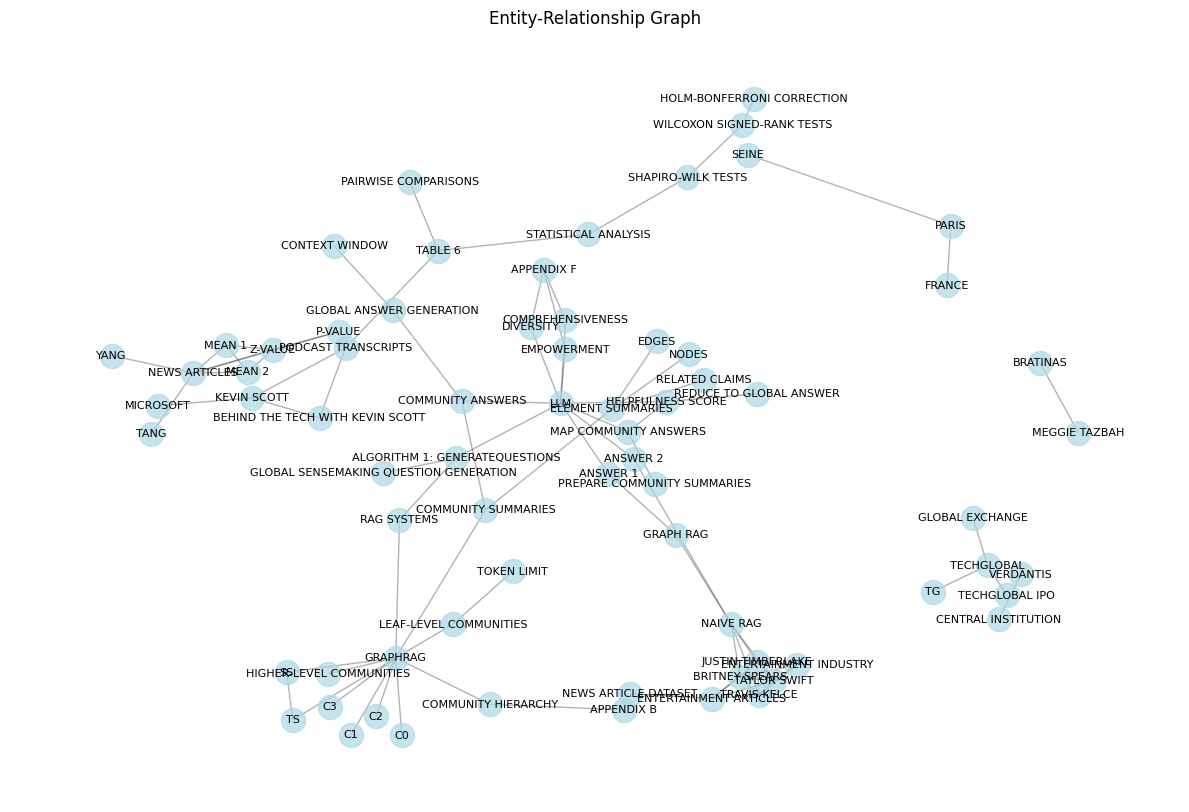

In [44]:
# Visualize graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, iterations=50)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis('off')
plt.tight_layout()
plt.title("Entity-Relationship Graph")
plt.show()

## 10. Data Exploration

In [45]:
# Top entities by degree
print("Top entities by degree:")
print(entity_df.nlargest(10, 'degree')[['title', 'type', 'degree']])

# Entity type distribution
print("\nEntity types:")
print(entity_df['type'].value_counts())

Top entities by degree:
                     title          type  degree
0                 GRAPHRAG  ORGANIZATION      11
1                      LLM  ORGANIZATION       9
30           NEWS ARTICLES         EVENT       6
39            TAYLOR SWIFT        PERSON       6
40            TRAVIS KELCE        PERSON       6
41          BRITNEY SPEARS        PERSON       6
42       JUSTIN TIMBERLAKE        PERSON       6
44               NAIVE RAG  ORGANIZATION       6
45  ENTERTAINMENT ARTICLES         EVENT       5
9        ELEMENT SUMMARIES         EVENT       4

Entity types:
type
EVENT           42
ORGANIZATION    12
PERSON           7
                 5
GEO              5
Name: count, dtype: int64


In [46]:
# Community structure
print("Community reports:")
print(report_df[['title', 'level', 'rank']])

# Relationship weights
print("\nTop relationships by weight:")
print(relationship_df.nlargest(10, 'weight')[['source', 'target', 'weight']])

Community reports:
                                                title  level  rank
0   RAG Systems — Algorithm 1 and Global Sensemaki...      1   6.5
1   Graph RAG and 'Answer 1' (retrieval-augmented ...      1   3.5
2   LLM–Centered Evaluation Community (LLM, Answer...      1   6.0
3         Community Hierarchy — GraphRAG & Appendix B      1   2.0
4           GRAPHRAG (GraphRAG) and Baselines SS / TS      1   6.0
5   Leaf-Level Communities and Token Limit Constra...      1   3.0
6   LLM-driven RAG Evaluation (Graph RAG vs Naive ...      0   6.5
7   Naive RAG identification of entertainment figu...      0   6.5
8   Community Summaries → Community Answers → Glob...      0   6.8
9   GraphRAG and the Community-hierarchy RAG Frame...      0   6.5
10  Prepare → Map → Helpfulness → Reduce: Communit...      0   6.5

Top relationships by weight:
      source                          target  weight
68        TG                      TECHGLOBAL    10.0
77    FRANCE                           PA